<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# METAR Staion Plot with MetPy
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/metars_preview.png" alt="Sample image of the METARS station plot map produced with this notebook" style="height: 300px;"></div>


# Objectives

* Use python-awips to connect to an edex server
* Define and filter data request for METAR surface obs
* Extract necessary data and reformat it for plotting
* Stylize and plot METAR station data using Cartopy, Matplotlib, and MetPy

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Function:-get_cloud_cover()" data-toc-modified-id="Function:-get_cloud_cover()-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function: get_cloud_cover()</a></span></li><li><span><a href="#Initial-Setup" data-toc-modified-id="Initial-Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial Setup</a></span><ul class="toc-item"><li><span><a href="#Initial-EDEX-Connection" data-toc-modified-id="Initial-EDEX-Connection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Initial EDEX Connection</a></span></li><li><span><a href="#Setting-Connection-Location-Names" data-toc-modified-id="Setting-Connection-Location-Names-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Setting Connection Location Names</a></span></li></ul></li><li><span><a href="#Filter-by-Time" data-toc-modified-id="Filter-by-Time-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Filter by Time</a></span></li><li><span><a href="#Use-the-Data!" data-toc-modified-id="Use-the-Data!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use the Data!</a></span><ul class="toc-item"><li><span><a href="#Get-the-Data!" data-toc-modified-id="Get-the-Data!-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Get the Data!</a></span></li><li><span><a href="#Extract-all-Parameters" data-toc-modified-id="Extract-all-Parameters-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Extract all Parameters</a></span></li><li><span><a href="#Populate-the-Data-Dictionary" data-toc-modified-id="Populate-the-Data-Dictionary-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Populate the Data Dictionary</a></span></li></ul></li><li><span><a href="#Plot-the-Data!" data-toc-modified-id="Plot-the-Data!-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot the Data!</a></span></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Related-Notebooks" data-toc-modified-id="Related-Notebooks-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Related Notebooks</a></span></li><li><span><a href="#Additional-Documentation" data-toc-modified-id="Additional-Documentation-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Additional Documentation</a></span></li></ul></li></ul></div>

## Imports

The imports below are used throughout the notebook.  Note the first two imports are coming directly from python-awips and allow us to connect to an EDEX server, and define a timrange used for filtering the data.  The subsequent imports are for data manipulation and visualization. 

In [1]:
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.calc import wind_components
from metpy.plots import StationPlot, StationPlotLayout, sky_cover
from metpy.units import units

<a href="#top">Top</a>

---

## Function: get_cloud_cover()

Returns the cloud fraction values as integer codes (0 through 8).

In [2]:
def get_cloud_cover(code):
    if 'OVC' in code:
        return 8
    elif 'BKN' in code:
        return 6
    elif 'SCT' in code:
        return 4
    elif 'FEW' in code:
        return 2
    else:
        return 0

<a href="#top">Top</a>

---

## Initial Setup

### Initial EDEX Connection

First we establish a connection to Unidata's public EDEX server.  With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to ***obs***.

Then, because we're going to uses MetPy's [StationPlot](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html) and [StationPlotLayout](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlotLayout.html) we need to define several parameters, and then set them on the data request object.

In [3]:
# EDEX Request
edexServer = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest("obs")

# define desired parameters
single_value_params = ["timeObs", "stationName", "longitude", "latitude", 
                       "temperature", "dewpoint", "windDir",
                       "windSpeed"]
multi_value_params = ["skyCover"]

params = single_value_params + multi_value_params

# set all parameters on the request
request.setParameters(*(params))

### Setting Connection Location Names

We are also going to define specific station IDs so that our plot is not too cluttered.  

In [4]:
# Define a list of station IDs to plot
selected = ['KPDX', 'KOKC', 'KICT', 'KGLD', 'KMEM', 'KBOS', 'KMIA', 'KMOB', 'KABQ', 'KPHX', 'KTTF',
            'KORD', 'KBIL', 'KBIS', 'KCPR', 'KLAX', 'KATL', 'KMSP', 'KSLC', 'KDFW', 'KNYC', 'KPHL',
            'KPIT', 'KIND', 'KOLY', 'KSYR', 'KLEX', 'KCHS', 'KTLH', 'KHOU', 'KGJT', 'KLBB', 'KLSV',
            'KGRB', 'KCLT', 'KLNK', 'KDSM', 'KBOI', 'KFSD', 'KRAP', 'KRIC', 'KJAN', 'KHSV', 'KCRW',
            'KSAT', 'KBUY', 'K0CO', 'KZPC', 'KVIH', 'KBDG', 'KMLF', 'KELY', 'KWMC', 'KOTH', 'KCAR',
            'KLMT', 'KRDM', 'KPDT', 'KSEA', 'KUIL', 'KEPH', 'KPUW', 'KCOE', 'KMLP', 'KPIH', 'KIDA', 
            'KMSO', 'KACV', 'KHLN', 'KBIL', 'KOLF', 'KRUT', 'KPSM', 'KJAX', 'KTPA', 'KSHV', 'KMSY',
            'KELP', 'KRNO', 'KFAT', 'KSFO', 'KNYL', 'KBRO', 'KMRF', 'KDRT', 'KFAR', 'KBDE', 'KDLH',
            'KHOT', 'KLBF', 'KFLG', 'KCLE', 'KUNV']

# set the location names to the desired station IDs 
request.setLocationNames(*(selected))

<a href="#top">Top</a>

---

## Filter by Time

Here we decide how much data we want to pull from EDEX.  By default we'll request 1 hour, but that value can easily be modified by [adjusting the `timedelta(hours = 1)`](https://docs.python.org/3/library/datetime.html#timedelta-objects) in line `2`.  The more data we request, the longer this section will take to run.

In [5]:
# Time range
lastHourDateTime = datetime.utcnow() - timedelta(hours = 1)
start = lastHourDateTime.strftime('%Y-%m-%d %H')
beginRange = datetime.strptime( start + ":00:00", "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( start + ":59:59", "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)

<a href="#top">Top</a>

---

## Use the Data!
### Get the Data!

Now that we have our `request` and TimeRange `timerange` objects ready, we're ready to get the data array from EDEX.

In [6]:
# Get response
response = DataAccessLayer.getGeometryData(request,timerange)

### Extract all Parameters

In this section we start gathering all the information we'll need to properly display our data. First we create an empty dictionary and array to keep track of all data and unique station IDs.  We also create a boolean to help us only grab the first entry for `skyCover` related to a station id.

<br>
<div class="alert-info">
    <b>Note:</b>  The way the data responses are returned, we recieve many <code>skyCover</code> entries for each station ID, but we only want to keep track of the most recent one (first one returned).
</div>

After defining these variables, we are ready to start looping through our response data.  If the response is an entry of `skyCover`, and this is a new station id, then set the skyCover value in the obs dictionary.  If this is not a skyCover entry, then explicitly set the `timeObs` variable (because we have to manipulate it slightly), and dynamically set all the remaining parameters.

In [7]:
# define a dictionary and array that will be populated from our for loop below
obs = dict({params: [] for params in params})
station_names = []

# only grab the first skyCover record related to a station 
new_station_id = True
# cycle through all the data in the response
for ob in response:
    avail_params = ob.getParameters()
    # if it has cloud information and is the first entry for this station id
    if "skyCover" in avail_params and new_station_id:
        # store the associated cloud cover int for the skyCover string
        obs['skyCover'].append(get_cloud_cover(ob.getString("skyCover")))
        new_station_id = False
    elif "stationName" in avail_params:
        new_station_id=True
        # If we already have a record for this stationName, skip
        if ob.getString('stationName') not in station_names:
            station_names.append(ob.getString('stationName'))
            for param in single_value_params:            
                if param in avail_params:
                    if param == 'timeObs':
                        obs[param].append(datetime.fromtimestamp(ob.getNumber(param)/1000.0))
                    else:
                        try:
                            obs[param].append(ob.getNumber(param))
                        except TypeError:
                            obs[param].append(ob.getString(param))
                else:
                    obs[param].append(None)

### Populate the Data Dictionary

Next grab the variables out of the obs dictionary we just populated, attach correct units, (calculate their components, in the instance of wind) and put them into a new dictionary that we will hand the plotting function later.

In [8]:
data = dict()
data['stid'] = np.array(obs['stationName'])
data['latitude']  = np.array(obs['latitude'])
data['longitude'] = np.array(obs['longitude'])
data['air_temperature'] = np.array(obs['temperature'], dtype=float)* units.degC
data['dew_point_temperature'] = np.array(obs['dewpoint'], dtype=float)* units.degC

direction = np.array(obs['windDir'])
direction[direction == -9999.0] = 'nan'

u, v = wind_components(np.array(obs['windSpeed']) * units('knots'),
                           direction * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v
data['cloud_coverage'] = np.array(obs['skyCover'])

<a href="#top">Top</a>

---

## Plot the Data!

Now we have all the data we need to create our plot!  First we'll assign a projection and create our figure and axes.

Next, we use Cartopy to add common features (land, ocean, lakes, borders, etc) to help give us a more contextual map of the United States to plot the METAR stations on.  We create and add a title for our figure as well.

Additionally, we use [MetPy's StationPlotLayout](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlotLayout.html) to instantiate a custom layout and define all the attributes we want displayed.  We need to then set the data dictionary (containing all of our data values) on the custom layout so it knows what to draw.

Finally, we display the plot!

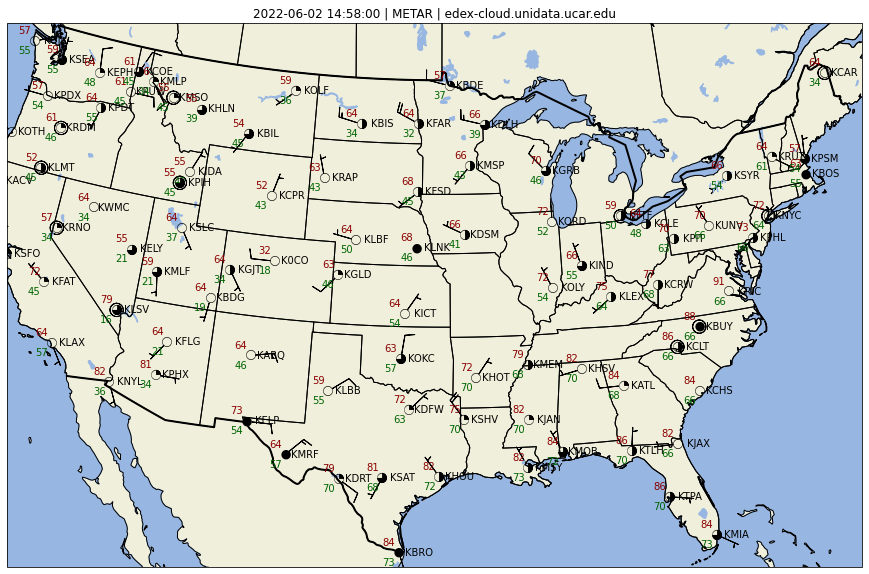

In [9]:
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
# Create the figure
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add various map elements
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
ax.set_extent((-118, -73, 23, 50))
ax.set_title(str(ob.getDataTime()) + " | METAR | " + edexServer)

# Winds, temps, dewpoint, station id
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots')
custom_layout.add_value('NW', 'air_temperature', fmt='.0f', units='degF', color='darkred')
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.0f', units='degF', color='darkgreen')
custom_layout.add_symbol('C', 'cloud_coverage', sky_cover)

stationplot = StationPlot(ax, data['longitude'], data['latitude'], clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=10)
stationplot.plot_text((2, 0), data['stid'])
custom_layout.plot(stationplot, data)

plt.show()

<a href="#top">Top</a>

---

## See Also

- [Aviation Weather Center Static METAR Plots Information](https://www.aviationweather.gov/metar/help?page=plot)

### Related Notebooks

- [Grid Levels and Parameters](http://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)
- [Colored Surface Temperature Plot](http://unidata.github.io/python-awips/examples/generated/Colored_Surface_Temperature_Plot.html)

### Additional Documentation

**python-awips:**

- [DataAccessLayer.changeEDEXHost()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.changeEDEXHost)
- [DataAccessLayer.newDataRequest()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.newDataRequest)
- [IDataRequest](http://unidata.github.io/python-awips/api/IDataRequest.html)
- [DataAccessLayer.getGeometryData](http://unidata.github.io/python-awips/api/PyGeometryData.html)

**datetime:**

- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects)
- [datetime.utcnow()](https://docs.python.org/3/library/datetime.html?#datetime.datetime.utcnow)
- [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects)
- [datetime.strftime() and datetime.strptime()](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

**numpy:**

- [np.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)

**cartopy:**

- [cartopy projection list](https://scitools.org.uk/cartopy/docs/v0.14/crs/projections.html?#cartopy-projection-list)
- [cartopy feature interface](https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html)

**matplotlib:**

- [matplotlib.pyplot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
- [matplotlib.pyplot.figure()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)
- [matplotlib.pyplot.figure.add_subplot](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.add_subplot)
- [ax.set_extent](https://matplotlib.org/stable/api/image_api.html?highlight=set_extent#matplotlib.image.AxesImage.set_extent)
- [ax.set_title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)


**metpy:**

- [metpy.calc.wind_components](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_components.html)
- [metpy.plots.StationPlot()](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html)
- [metpy.plots.StationPlotLayout()](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlotLayout.html)
- [metpy.units](https://unidata.github.io/MetPy/latest/api/generated/metpy.units.html)


<a href="#top">Top</a>

---